In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [2]:
from pyfrac.modelling.kirchhoff import Kirchhoff

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage
from pyfrac.visualisation.eventimages import locimage3d

-----------------

# SETUP - MODEL, REC GEOM, SOURCES

In [3]:
# Velocity Model
nx, ny, nz = 50, 50, 50
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

In [4]:
# RECEIVERS
dr_xyz = 4*dx

grid_rx_locs = np.arange(dx, (dx*nx)-dx, dr_xyz)
grid_ry_locs = np.arange(dy, (dy*ny)-dy, dr_xyz)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

In [5]:
# Microseismic sources
sx, sy, sz = [nx//4, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

---------------

# MAKE DATA

In [6]:
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

In [7]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs[:, :1], 
               recs=recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='eikonal', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-5475.474483628965 - u^H(Op^Hv)=-5475.474483628983


Text(0.5, 1.0, 'Point Receivers')

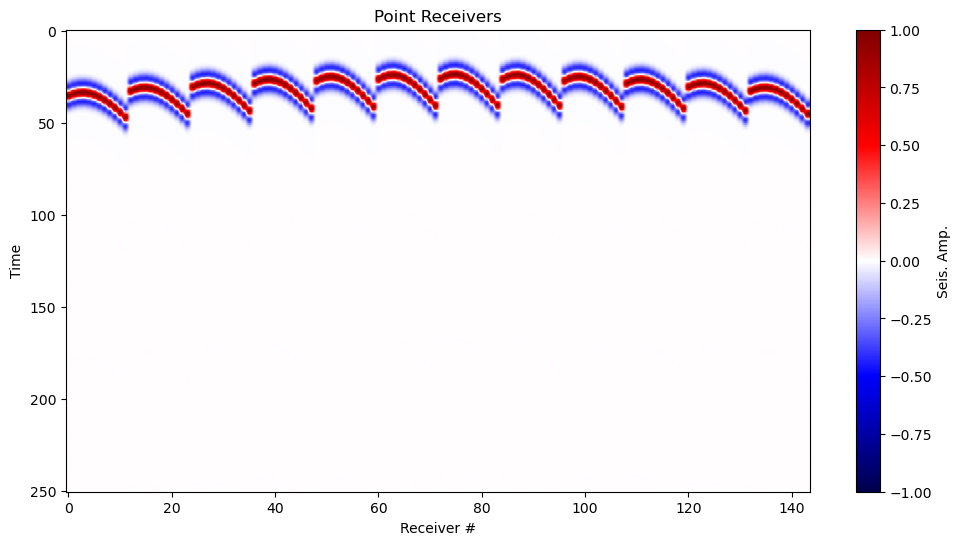

In [8]:
# PERFORM FORWARD (MODEL)
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
ax = traceimage(frwddata, climQ=99.99)
ax.set_title('Point Receivers')

-------------------

# MIGRATE - An Inverse Crime
## Doesn't work in real life as assumes modelling operator can be applied in reverse and return location, i.e., requires data was actually made with the operator (e.g., synthetic)

In [11]:
from pyfrac.locationsolvers.imaging import *
from pyfrac.locationsolvers.crosscorr_imaging import xcorr_imaging

Hypo Center: [11.9 25.  24.9]


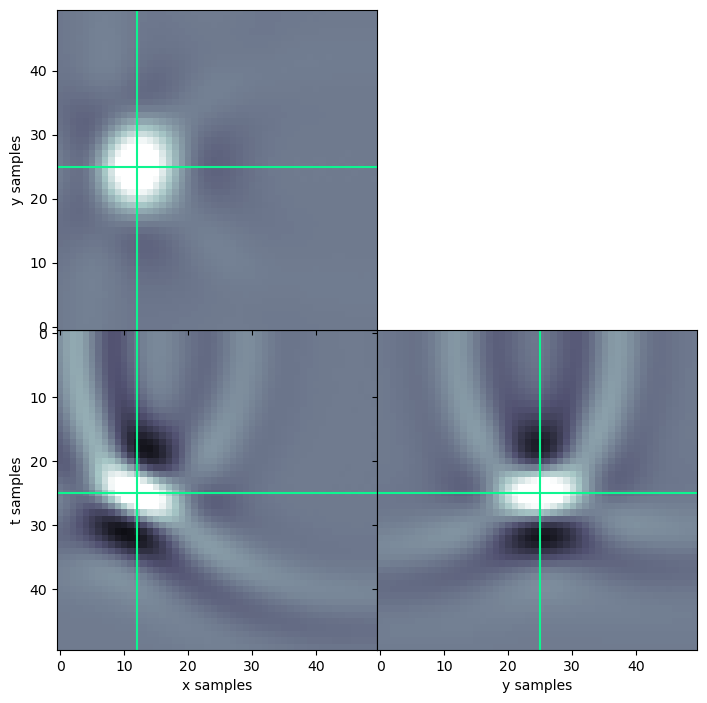

In [10]:
migrated = (Op.H @ frwddata).reshape(nx,ny,nz)
print('Migration Hypo-Centers:', mig_hc)

fig,axs = locimage3d(migrated,sx,sy)

--------------------------------

# INVERSION

In [21]:
inv, inv_hc = lsqr_migration(Op, frwddata, [nx,ny,nz], nforhc=10, verbose=False)
fista, fista_hc = fista_migration(Op, frwddata, [nx,ny,nz], nforhc=10, verbose=False, fista_eps=1e1)

In [22]:
print('LSQR Inversion Hypo-Centers:', inv_hc)
print('FISTA Inversion Hypo-Centers:', fista_hc)

LSQR Inversion Hypo-Centers: [11.9 25.  24.9]
FISTA Inversion Hypo-Centers: [11.9 25.  24.9]


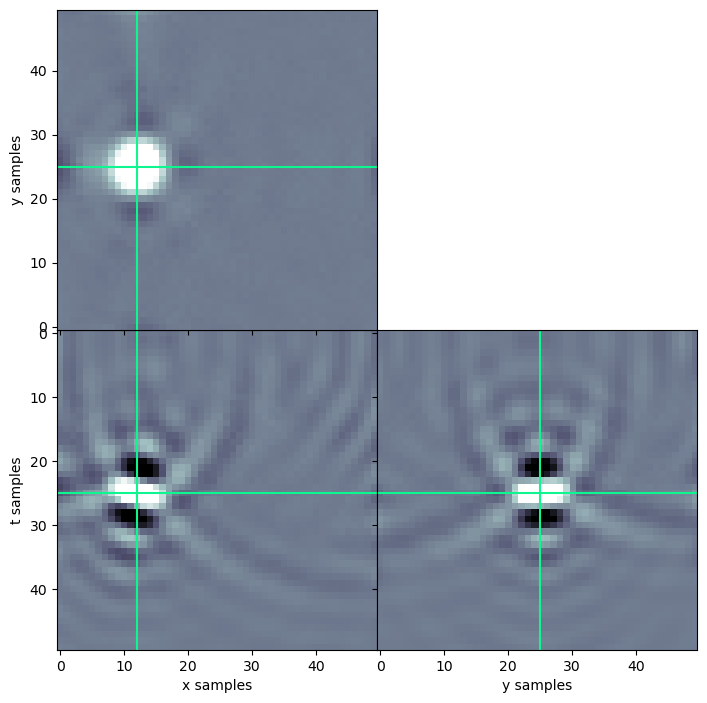

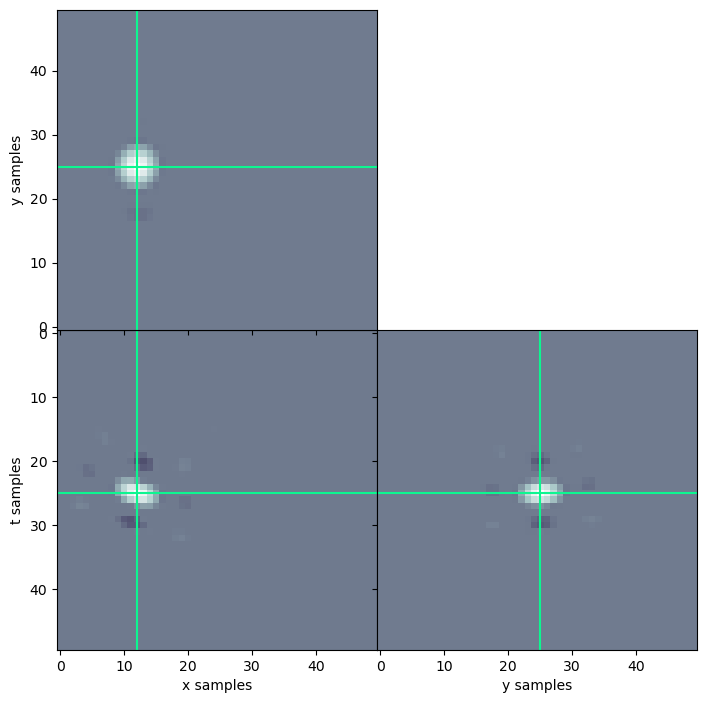

In [23]:

fig,axs = locimage3d(inv, x0=sx, y0=sy)
fig,axs = locimage3d(fista, x0=sx, y0=sy, p=100)

Iteration 0, Loss: 2.83889
Iteration 10, Loss: 0.57628
Iteration 20, Loss: 0.01414
Iteration 30, Loss: -0.31768
Iteration 40, Loss: -0.41163
Iteration 50, Loss: -0.54786
Iteration 60, Loss: -0.58172
Iteration 70, Loss: -0.64622
Iteration 80, Loss: -0.66091
Iteration 90, Loss: -0.69270
X-Corr Imaging Hypo-Center: [11.9 25.  24.9]


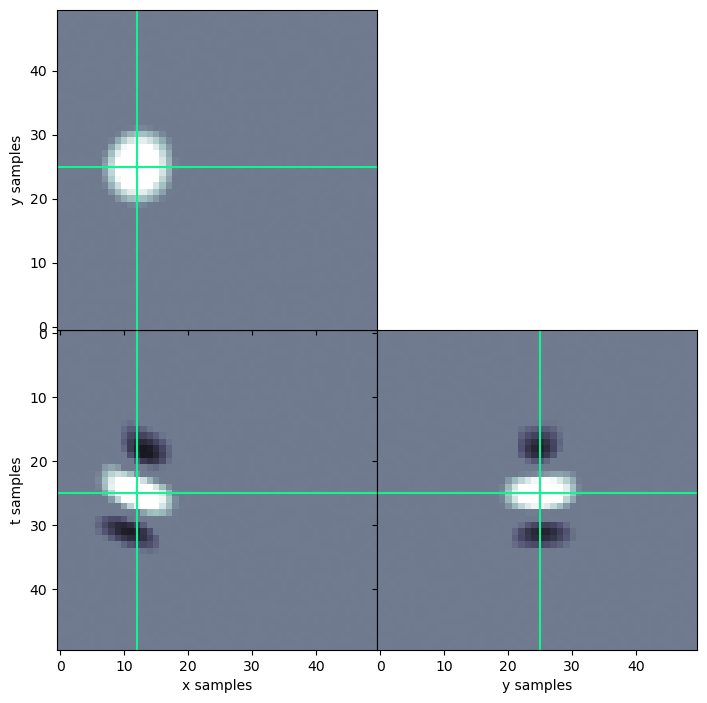

In [20]:
XC_inv, xci_hc, dls_torch, losshist = xcorr_imaging(Op, 
                                                    frwddata, 
                                                    [nx,ny,nz], 
                                                    niter=100, 
                                                    xceps=8e-1, 
                                                    lr=1e-5, 
                                                    nforhc=10, 
                                                    verbose=True)

print('X-Corr Imaging Hypo-Center:', xci_hc)
fig,axs = locimage3d(XC_inv, x0=sx, y0=sy)